In [1]:
from matplotlib import pyplot as plt
from matplotlib.dates import DateFormatter
import numpy as np
import xarray as xr
import pandas as pd
import scipy
from datetime import datetime, timedelta
import time
import seaborn
import matplotlib.dates as mdates
import bottleneck as bn
import PyCO2SYS as pyco2
import gsw
import math
import netCDF4 as nc
import requests

import chemO_funcs #import o2sat
from importlib import reload
import warnings
warnings.filterwarnings('ignore')
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
%run ./chemO_funcs.py

# Open nc file for GFDL-ESM4 1995 to 2014

In [2]:
ds = xr.open_mfdataset('/Users/akbaskind/Desktop/YoE/GFDLESM4historical.nc')

## Add in omega
When I saved the dataset, I forgot to calculate this with `PyCO2SYS`. Here I add that in, including the conversion factor.

In [3]:
conv = 1e6/(1000+ds['sigma0'])
results_omega = pyco2.sys(par1=ds['talk']*conv,par2=ds['dissic']*conv,
                       par1_type=1,par2_type=2, salinity = ds['sos'], temperature = ds['tos'])


In [7]:
ds['omega'] = results_omega['saturation_aragonite']* xr.ones_like(ds['talk'])
ds['omega'].attrs = {'description': 'Omega_arag calculate from PyCO2SYS using DIC, TA, temp, and sal',
                                 'name': 'aragonite saturation state'}
ds.omega

<xarray.DataArray 'omega' (time: 240, y: 180, x: 360)>
dask.array<multiply, shape=(240, 180, 360), dtype=float64, chunksize=(240, 180, 360), chunktype=numpy.ndarray>
Coordinates:
  * y               (y) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
    lat_bounds      (y, x) float64 dask.array<chunksize=(180, 360), meta=np.ndarray>
    lev             float64 ...
    lev_bounds      float64 ...
  * x               (x) float64 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
    lon_bounds      (x, y) float64 dask.array<chunksize=(360, 180), meta=np.ndarray>
  * time            (time) object 1995-01-16 12:00:00 ... 2014-12-16 12:00:00
    time_bounds     (time) object dask.array<chunksize=(240,), meta=np.ndarray>
    lon             (x, y) float64 dask.array<chunksize=(360, 180), meta=np.ndarray>
    lat             (x, y) float64 dask.array<chunksize=(360, 180), meta=np.ndarray>
    lon_verticies   (x, y) float64 dask.array<chunksize=(360, 180), meta=np.ndarray>
    lat_verticies   (x, y) float64 dask.array<chunksize=(360, 180), meta=np.ndarray>
    member_id       object ...
    dcpp_init_year  float64 ...
Attributes:
    description:  Omega_arag calculate from PyCO2SYS using DIC, TA, temp, and...
    name:         aragonite saturation state

# Resave nc file with omega

In [9]:
ds.to_netcdf('/Users/akbaskind/Desktop/YoE/GFDLESM4historical_omega.nc')

In [3]:
ds = xr.open_mfdataset('/Users/akbaskind/Desktop/YoE/GFDLESM4historical_omega.nc')

# Detrend fugacity, pH, and omega

currently, starting the detrend at year 1980. The current version of the SOCAT data detrends from each grid point's minimum year, so that needs to be corrected.

In [4]:
ds['fugacity_detrended'] = (ds['fugacity'] -  1.89 * (ds['fugacity'].time.dt.year - 1980)) * xr.ones_like(ds['talk'])
ds['ph_detrended'] = (ds['ph'] + 0.0018 * (ds['ph'].time.dt.year - 1980)) * xr.ones_like(ds['talk'])
ds['omega_detrended'] = (ds['omega'] + 0.0078 * (ds['omega'].time.dt.year - 1980)) * xr.ones_like(ds['talk'])

In [5]:
# ds['fugacity_detrended'] = xr.Variable(dims = ['time','y', 'x'], data = ds['fugacity'] -  1.89 * (ds['fugacity'].time.dt.year - 1980))
ds['fugacity_detrended'].attrs = {"units": 'uatm', 
                        'description': 'detrended fugacity. 1.89 uatm subtracted for every year since 1980',
                                 'name': 'fugacity detrended'}
ds['ph_detrended'].attrs = {"units": '', 'name': 'pH detrended', 
                        'description': 'detrended pH on total scale. 0.0018 added for every year since 1980'}
ds['omega_detrended'].attrs = {"units": '', 'name': 'Omega_arag detrended', 
                        'description': 'detrended Omega_arag calculated from PyCO2SYS: 0.0078 added for every year since 1980'}

# Mean and standard deviation

In [6]:
dsmean = ds.mean('time', keep_attrs = True)
dsstd = ds.std('time', keep_attrs = True)

In [71]:
axlist = np.arange(0, len(axs), 1)

# Plots for detrended data

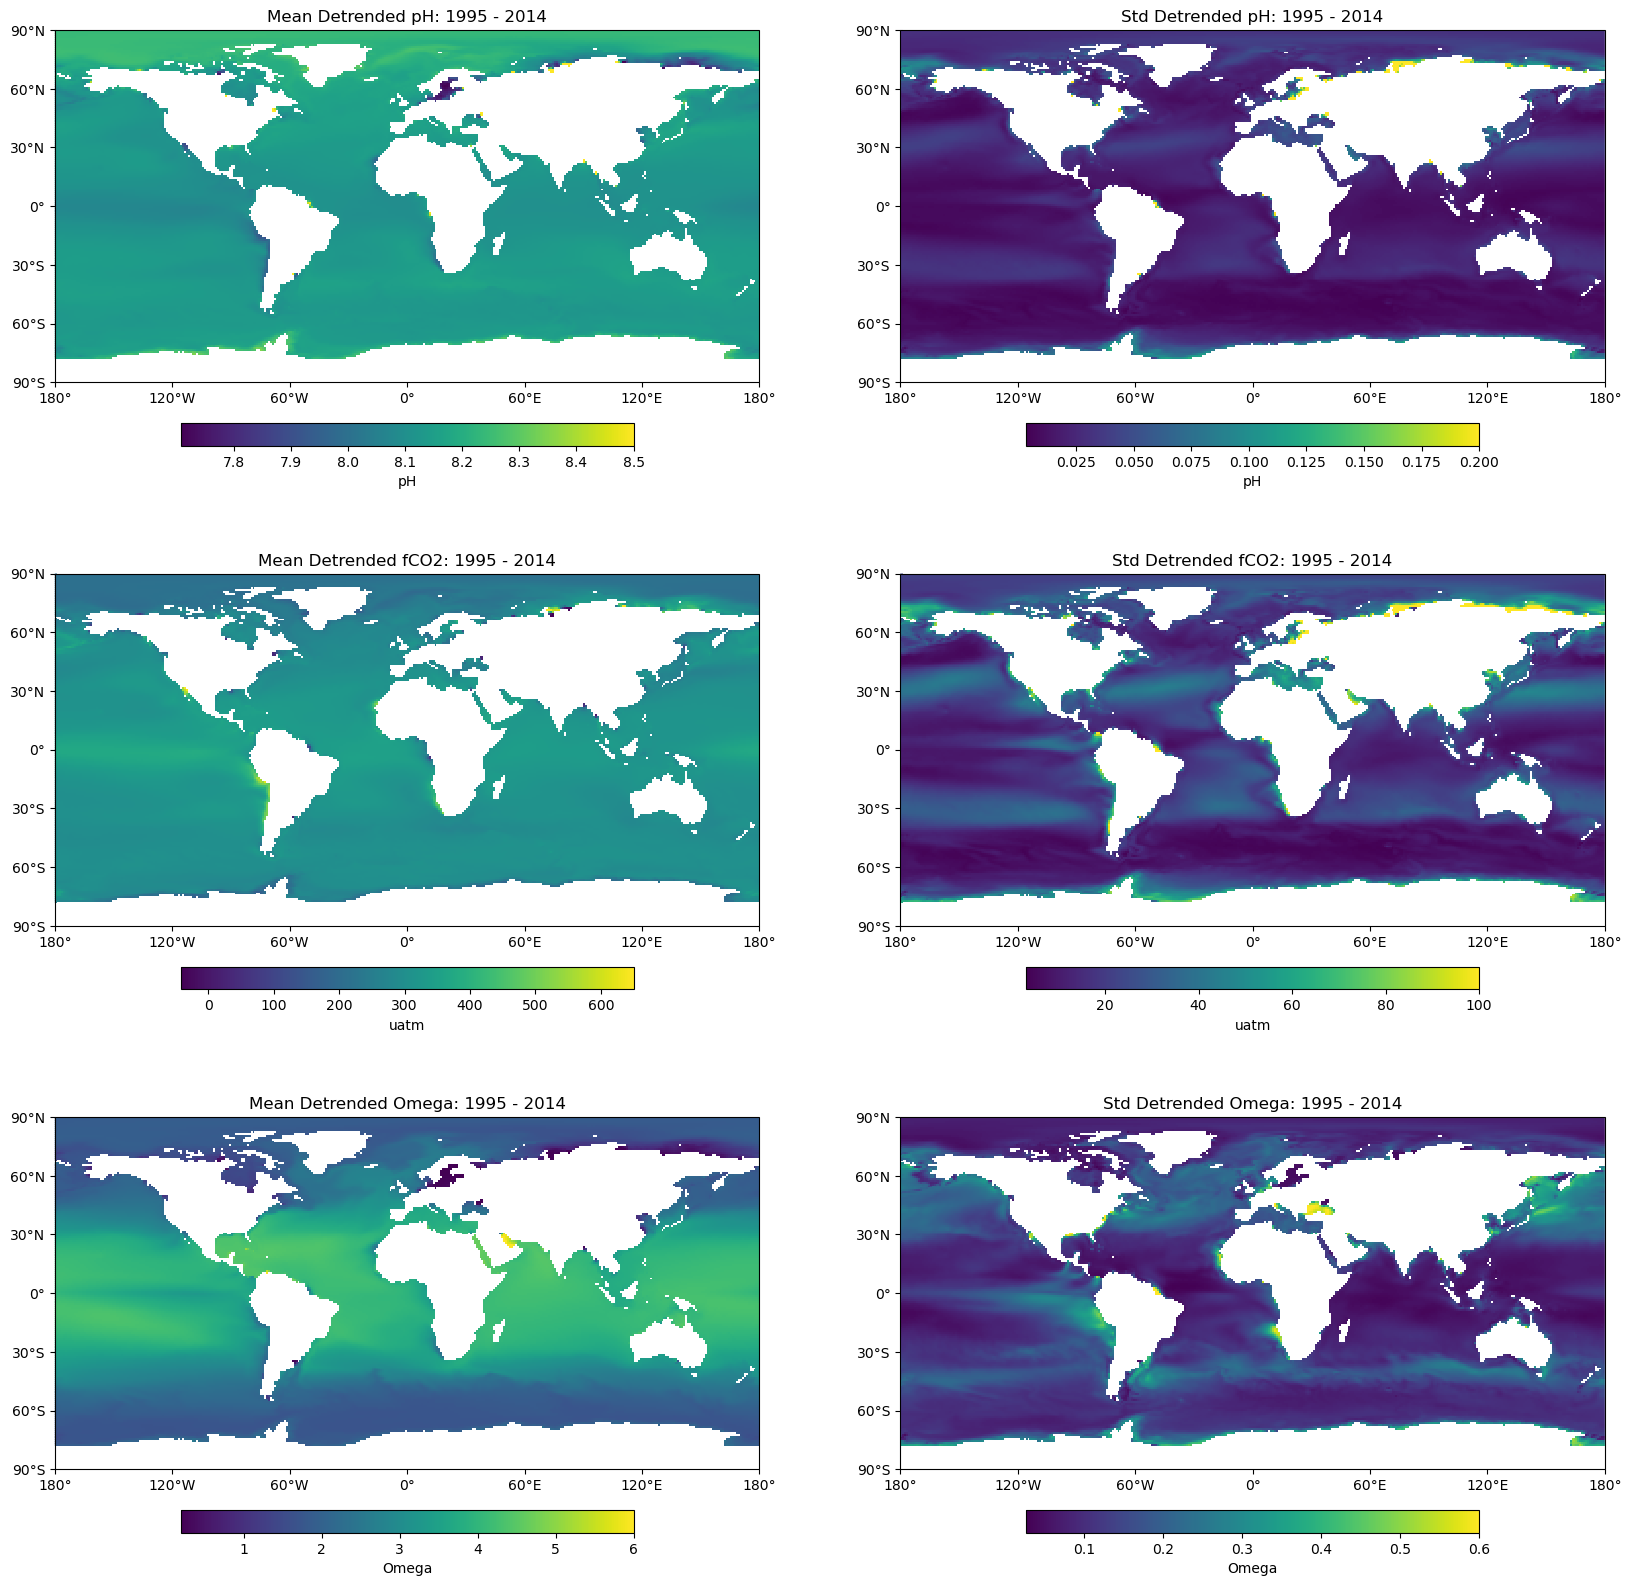

In [72]:
fig, axs = plt.subplots(nrows = 3, ncols = 2, figsize = [20,20],subplot_kw={'projection':ccrs.PlateCarree()})

axs = axs.flatten()

# Plot of mean detrended pH
phmean = axs[0].pcolormesh(dsmean.x, dsmean.y, dsmean.ph_detrended, vmax = 8.5)
cbar0 = plt.colorbar(phmean, ax = axs[0], orientation = 'horizontal', fraction = 0.05, pad = 0.09)
cbar0.set_label('pH')
axs[0].set_title('Mean Detrended pH: 1995 - 2014')

# Plot of detrended pH Std
phstd = axs[1].pcolormesh(dsstd.x, dsstd.y, dsstd.ph_detrended, vmax = 0.2)
cbar1 = plt.colorbar(phstd, ax = axs[1], orientation = 'horizontal', fraction = 0.05, pad = 0.09)
cbar1.set_label('pH')
axs[1].set_title('Std Detrended pH: 1995 - 2014')

# Plot of mean detrended fugacity
fco2mean = axs[2].pcolormesh(dsmean.x, dsmean.y, dsmean.fugacity_detrended, vmax = 650)
cbar2 = plt.colorbar(fco2mean, ax = axs[2], orientation = 'horizontal', fraction = 0.05, pad = 0.09)
cbar2.set_label(dsmean.fugacity_detrended.units)
axs[2].set_title('Mean Detrended fCO2: 1995 - 2014')

# Plot of detrended fugacity Std
fco2std = axs[3].pcolormesh(dsstd.x, dsstd.y, dsstd.fugacity_detrended, vmax = 100)
cbar3 = plt.colorbar(fco2std, ax = axs[3], orientation = 'horizontal', fraction = 0.05, pad = 0.09)
cbar3.set_label(dsstd.fugacity_detrended.units)
axs[3].set_title('Std Detrended fCO2: 1995 - 2014')

# Plot of mean detrended omega aragonite
omegamean = axs[4].pcolormesh(dsmean.x, dsmean.y, dsmean.omega_detrended, vmax = 6)
cbar4 = plt.colorbar(omegamean, ax = axs[4], orientation = 'horizontal', fraction = 0.05, pad = 0.09)
cbar4.set_label('Omega')
axs[4].set_title('Mean Detrended Omega: 1995 - 2014')

# Plot of detrended omega aragonite Std
omegastd = axs[5].pcolormesh(dsstd.x, dsstd.y, dsstd.omega_detrended, vmax = 0.6)
cbar5 = plt.colorbar(omegastd, ax = axs[5], orientation = 'horizontal', fraction = 0.05, pad = 0.09)
cbar5.set_label('Omega')
axs[5].set_title('Std Detrended Omega: 1995 - 2014')

# Add lat-lon to axes
for i in axlist:
        # Longitude labels
        axs[i].set_xticks(np.arange(-180,181,60), crs=ccrs.PlateCarree())
        lon_formatter = cticker.LongitudeFormatter()
        axs[i].xaxis.set_major_formatter(lon_formatter)

        # Latitude labels
        axs[i].set_yticks(np.arange(-90,91,30), crs=ccrs.PlateCarree())
        lat_formatter = cticker.LatitudeFormatter()
        axs[i].yaxis.set_major_formatter(lat_formatter)
        
fig.savefig('/Users/akbaskind/Desktop/YoE/GFDLESM4_detrended.png', bbox_inches='tight')

In [7]:
ds

<xarray.Dataset>
Dimensions:             (time: 240, y: 180, x: 360)
Coordinates: (12/14)
  * y                   (y) float64 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
    lat_bounds          (y, x) float64 dask.array<chunksize=(180, 360), meta=np.ndarray>
    lev                 float64 ...
    lev_bounds          float64 ...
  * x                   (x) float64 0.5 1.5 2.5 3.5 ... 356.5 357.5 358.5 359.5
    lon_bounds          (x, y) float64 dask.array<chunksize=(360, 180), meta=np.ndarray>
    ...                  ...
    lon                 (x, y) float64 dask.array<chunksize=(360, 180), meta=np.ndarray>
    lat                 (x, y) float64 dask.array<chunksize=(360, 180), meta=np.ndarray>
    lon_verticies       (x, y) float64 dask.array<chunksize=(360, 180), meta=np.ndarray>
    lat_verticies       (x, y) float64 dask.array<chunksize=(360, 180), meta=np.ndarray>
    member_id           object ...
    dcpp_init_year      float64 ...
Data variables: (12/15)
    talk                (time, y, x) float32 dask.array<chunksize=(240, 180, 360), meta=np.ndarray>
    co3sataragos        (time, y, x) float32 dask.array<chunksize=(240, 180, 360), meta=np.ndarray>
    fgco2               (time, y, x) float32 dask.array<chunksize=(240, 180, 360), meta=np.ndarray>
    co3os               (time, y, x) float32 dask.array<chunksize=(240, 180, 360), meta=np.ndarray>
    sos                 (time, y, x) float32 dask.array<chunksize=(240, 180, 360), meta=np.ndarray>
    ph                  (time, y, x) float32 dask.array<chunksize=(240, 180, 360), meta=np.ndarray>
    ...                  ...
    sigma0              (time, y, x) float64 dask.array<chunksize=(240, 180, 360), meta=np.ndarray>
    fugacity            (time, y, x) float64 dask.array<chunksize=(240, 180, 360), meta=np.ndarray>
    omega               (time, y, x) float64 dask.array<chunksize=(240, 180, 360), meta=np.ndarray>
    fugacity_detrended  (time, y, x) float64 dask.array<chunksize=(240, 180, 360), meta=np.ndarray>
    ph_detrended        (time, y, x) float64 dask.array<chunksize=(240, 180, 360), meta=np.ndarray>
    omega_detrended     (time, y, x) float64 dask.array<chunksize=(240, 180, 360), meta=np.ndarray>
Attributes: (12/49)
    Conventions:                      CF-1.7 CMIP-6.0 UGRID-1.0
    activity_id:                      CMIP
    branch_method:                    standard
    branch_time_in_child:             0.0
    branch_time_in_parent:            36500.0
    comment:                          <null ref>
    ...                               ...
    intake_esm_attrs:experiment_id:   historical
    intake_esm_attrs:member_id:       r1i1p1f1
    intake_esm_attrs:table_id:        Omon
    intake_esm_attrs:grid_label:      gr
    intake_esm_attrs:version:         20190726
    intake_esm_attrs:_data_format_:   zarr

# Begin comparison with SOCAT data
As of April 30, the SOCAT data is the version Hongjie made sometime last week. Detrending referenced to each grid point's min year.

In [8]:
da = xr.open_mfdataset('/Users/akbaskind/Desktop/YoE/SOCAT_akb.nc')

In [9]:
dsmean

<xarray.Dataset>
Dimensions:             (y: 180, x: 360)
Coordinates:
  * y                   (y) float64 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
    lat_bounds          (y, x) float64 dask.array<chunksize=(180, 360), meta=np.ndarray>
    lev                 float64 ...
    lev_bounds          float64 ...
  * x                   (x) float64 0.5 1.5 2.5 3.5 ... 356.5 357.5 358.5 359.5
    lon_bounds          (x, y) float64 dask.array<chunksize=(360, 180), meta=np.ndarray>
    lon                 (x, y) float64 dask.array<chunksize=(360, 180), meta=np.ndarray>
    lat                 (x, y) float64 dask.array<chunksize=(360, 180), meta=np.ndarray>
    lon_verticies       (x, y) float64 dask.array<chunksize=(360, 180), meta=np.ndarray>
    lat_verticies       (x, y) float64 dask.array<chunksize=(360, 180), meta=np.ndarray>
    member_id           object ...
    dcpp_init_year      float64 ...
Data variables: (12/15)
    talk                (y, x) float32 dask.array<chunksize=(180, 360), meta=np.ndarray>
    co3sataragos        (y, x) float32 dask.array<chunksize=(180, 360), meta=np.ndarray>
    fgco2               (y, x) float32 dask.array<chunksize=(180, 360), meta=np.ndarray>
    co3os               (y, x) float32 dask.array<chunksize=(180, 360), meta=np.ndarray>
    sos                 (y, x) float32 dask.array<chunksize=(180, 360), meta=np.ndarray>
    ph                  (y, x) float32 dask.array<chunksize=(180, 360), meta=np.ndarray>
    ...                  ...
    sigma0              (y, x) float64 dask.array<chunksize=(180, 360), meta=np.ndarray>
    fugacity            (y, x) float64 dask.array<chunksize=(180, 360), meta=np.ndarray>
    omega               (y, x) float64 dask.array<chunksize=(180, 360), meta=np.ndarray>
    fugacity_detrended  (y, x) float64 dask.array<chunksize=(180, 360), meta=np.ndarray>
    ph_detrended        (y, x) float64 dask.array<chunksize=(180, 360), meta=np.ndarray>
    omega_detrended     (y, x) float64 dask.array<chunksize=(180, 360), meta=np.ndarray>
Attributes: (12/49)
    Conventions:                      CF-1.7 CMIP-6.0 UGRID-1.0
    activity_id:                      CMIP
    branch_method:                    standard
    branch_time_in_child:             0.0
    branch_time_in_parent:            36500.0
    comment:                          <null ref>
    ...                               ...
    intake_esm_attrs:experiment_id:   historical
    intake_esm_attrs:member_id:       r1i1p1f1
    intake_esm_attrs:table_id:        Omon
    intake_esm_attrs:grid_label:      gr
    intake_esm_attrs:version:         20190726
    intake_esm_attrs:_data_format_:   zarr

# Create a dataset that will hold only the stds from GFDL-historical-present and SOCAT at grid cells where SOCAT data exist
All SOCAT coords are adjusted by 0.5 to align with GFDL-ESM4

In [12]:
dd = xr.Dataset()
dd = dd.assign_coords({'lat': np.arange(-89.5,90,1), 'lon': np.arange(0.5,360,1)})
dat = np.zeros((len(dd.lat), len(dd.lon)))
dat[:] = np.nan
dd['StdpH_detrended_SOCAT'] = xr.Variable(dims = ['lat','lon'], data = dat)
dd['StdfCO2_detrended_SOCAT'] = xr.Variable(dims = ['lat','lon'], data = dat)
dd['StdOmegaAr_detrended_SOCAT'] = xr.Variable(dims = ['lat','lon'], data = dat)
dd['StdpH_detrended_GFDL'] = xr.Variable(dims = ['lat','lon'], data = dat)
dd['StdfCO2_detrended_GFDL'] = xr.Variable(dims = ['lat','lon'], data = dat)
dd['StdOmegaAr_detrended_GFDL'] = xr.Variable(dims = ['lat','lon'], data = dat)
dd

<xarray.Dataset>
Dimensions:                     (lat: 180, lon: 360)
Coordinates:
  * lat                         (lat) float64 -89.5 -88.5 -87.5 ... 88.5 89.5
  * lon                         (lon) float64 0.5 1.5 2.5 ... 357.5 358.5 359.5
Data variables:
    StdpH_detrended_SOCAT       (lat, lon) float64 nan nan nan ... nan nan nan
    StdfCO2_detrended_SOCAT     (lat, lon) float64 nan nan nan ... nan nan nan
    StdOmegaAr_detrended_SOCAT  (lat, lon) float64 nan nan nan ... nan nan nan
    StdpH_detrended_GFDL        (lat, lon) float64 nan nan nan ... nan nan nan
    StdfCO2_detrended_GFDL      (lat, lon) float64 nan nan nan ... nan nan nan
    StdOmegaAr_detrended_GFDL   (lat, lon) float64 nan nan nan ... nan nan nan

## Fill comparison dataset (called `temp`)

Basically, this loops through all lat and lon points. If SOCAT data exist at that coordinate, append the coords and the detrended stds for pH, fugacity, and omega for both GFDL-historical-present and SOCAT.

In [64]:
temp = {'Lat':[], 'Lon': [], 'GFDL Std Fugacity Detrended': [], 'SOCAT Std Fugacity Detrended': [],
       'GFDL Std pH Detrended': [], 'SOCAT Std pH Detrended': [],
       'GFDL Std Omega Detrended': [], 'SOCAT Std Omega Detrended': []}
for i in np.arange(-89.5,90,1):
    for j in np.arange(0.5,360,1):
        # dd.lat.values:
        if math.isnan(da['StdpH'].sel(lon = j, lat = i).values.tolist()) == False:
            temp['Lon'].append(j)
            temp['Lat'].append(i)
            temp['GFDL Std Fugacity Detrended'].append(dsstd['fugacity_detrended'].sel(x = j, y = i, method = 'nearest').values.tolist())
            temp['SOCAT Std Fugacity Detrended'].append(da['StdfCO2_detrended'].sel(lon = j, lat = i).values.tolist())
            temp['GFDL Std pH Detrended'].append(dsstd['ph_detrended'].sel(x = j, y = i, method = 'nearest').values.tolist())
            temp['SOCAT Std pH Detrended'].append(da['StdpH_detrended'].sel(lon = j, lat = i).values.tolist())
            temp['GFDL Std Omega Detrended'].append(dsstd['omega_detrended'].sel(x = j, y = i, method = 'nearest').values.tolist())
            temp['SOCAT Std Omega Detrended'].append(da['StdOmegaAr_detrended'].sel(lon = j, lat = i).values.tolist())
        # a = da['StdpH'].where(da['lon'] == j).where(da['lat'] == i)
        # if a.size > 0:
        #     dd["minYr"] = xr.where((dd.coords["lat"] == i) & (dd.coords["lon"] == j), a['minYr'].values[0], dd["minYr"])
        #     dd["maxYr"] = xr.where((dd.coords["lat"] == i) & (dd.coords["lon"] == j), a['maxYr'].values[0], dd["maxYr"])
        #     dd["UniqueYrs"] = xr.where((dd.coords["lat"] == i) & (dd.coords["lon"] == j), a['UniqueYrs'].values[0], dd["UniqueYrs"])
        #     dd["StdpH"] = xr.where((dd.coords["lat"] == i) & (dd.coords["lon"] == j), a['StdpH'].values[0], dd["StdpH"])
        #     dd["StdfCO2"] = xr.where((dd.coords["lat"] == i) & (dd.coords["lon"] == j), a['StdfCO2'].values[0], dd["StdfCO2"])
        #     dd["StdOmegaAr"] = xr.where((dd.coords["lat"] == i) & (dd.coords["lon"] == j), a['StdOmegaAr'].values[0], dd["StdOmegaAr"])
        #     dd["StdpH_detrended"] = xr.where((dd.coords["lat"] == i) & (dd.coords["lon"] == j), a['StdpH_detrended'].values[0], dd["StdpH_detrended"])
        #     dd["StdfCO2_detrended"] = xr.where((dd.coords["lat"] == i) & (dd.coords["lon"] == j), a['StdfCO2_detrended'].values[0], dd["StdfCO2_detrended"])
        #     dd["StdOmegaAr_detrended"] = xr.where((dd.coords["lat"] == i) & (dd.coords["lon"] == j), a['StdOmegaAr_detrended'].values[0], dd["StdOmegaAr_detrended"])

In [66]:
tempdf = pd.DataFrame(temp)

### Save as a csv since this took forever to run 
And I shouldn't run it every time

In [75]:
tempdf.to_csv('/Users/akbaskind/Desktop/YoE/GFDLESM4_SOCAT_Apr30.csv')

In [74]:
tempdf

,Lat,Lon,GFDL Std Fugacity Detrended,SOCAT Std Fugacity Detrended,GFDL Std pH Detrended,SOCAT Std pH Detrended,GFDL Std Omega Detrended,SOCAT Std Omega Detrended
0,-77.5,165.5,70.547337,33.870,0.110249,0.055698,0.457998,0.24847
1,-77.5,166.5,71.559301,37.207,0.108069,0.064189,0.452185,0.28431
2,-77.5,167.5,79.461308,75.969,0.113619,0.125970,0.516945,0.54114
3,-77.5,173.5,67.287808,59.793,0.088098,0.074923,0.370652,0.27120
4,-77.5,174.5,67.244093,70.196,0.088105,0.092031,0.371687,0.33931
...,...,...,...,...,...,...,...,...
3831,79.5,4.5,35.943472,38.760,0.050861,0.067638,0.175218,0.33890
3832,79.5,5.5,36.912493,32.603,0.051723,0.054672,0.176983,0.25378
3833,79.5,6.5,37.536069,36.510,0.052407,0.054717,0.180557,0.27887
3834,79.5,7.5,37.485514,50.109,0.052281,0.070434,0.186295,0.35763


## Plot comparing detrended stds from SOCAT and GFDL-historical-present

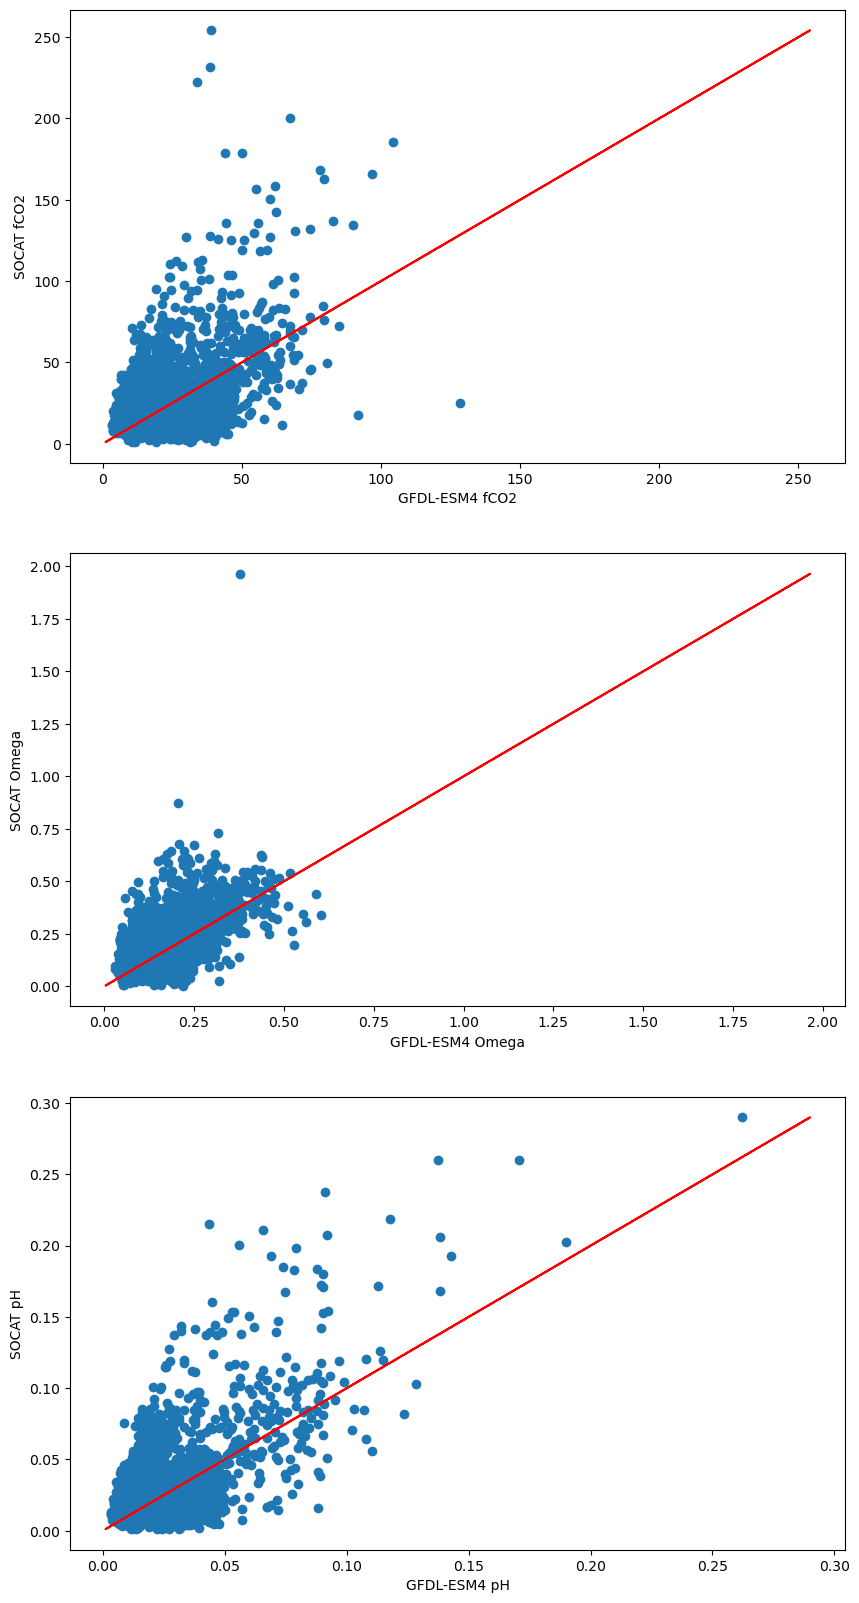

In [80]:
fig, axs = plt.subplots(nrows = 3, figsize = [10,20])
axs = axs.flatten()

axs[0].scatter(tempdf['GFDL Std Fugacity Detrended'], tempdf['SOCAT Std Fugacity Detrended'])
axs[0].plot(tempdf['SOCAT Std Fugacity Detrended'], tempdf['SOCAT Std Fugacity Detrended'], color = 'red')
axs[0].set_xlabel('GFDL-ESM4 fCO2')
axs[0].set_ylabel('SOCAT fCO2')

axs[1].scatter(tempdf['GFDL Std Omega Detrended'], tempdf['SOCAT Std Omega Detrended'])
axs[1].plot(tempdf['SOCAT Std Omega Detrended'], tempdf['SOCAT Std Omega Detrended'], color = 'red')
axs[1].set_xlabel('GFDL-ESM4 Omega')
axs[1].set_ylabel('SOCAT Omega')

axs[2].scatter(tempdf['GFDL Std pH Detrended'], tempdf['SOCAT Std pH Detrended'])
axs[2].plot(tempdf['SOCAT Std pH Detrended'], tempdf['SOCAT Std pH Detrended'], color = 'red')
axs[2].set_xlabel('GFDL-ESM4 pH')
axs[2].set_ylabel('SOCAT pH')

fig.savefig('/Users/akbaskind/Desktop/YoE/GFDLESM4_v_SOCAT_Apr30.png', bbox_inches='tight')